# Here is the same basic setup for a CNN pipeline but with with sparse data

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
tf.__version__



'2.8.0'

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

## code for viewing images from dataset

In [4]:
example = ds_train.take(1)
example

<TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

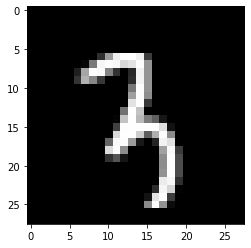

Label: 3


In [5]:
for sample in example:
    image, label = sample[0].numpy(), sample[1].numpy()
    plt.imshow(image[:, :, 0].astype(np.uint8), cmap=plt.get_cmap("gray"))
    plt.show()
    print("Label: %d" % label)

In [6]:
tf.random.uniform((6,8), maxval=2,dtype='int32')

<tf.Tensor: shape=(6, 8), dtype=int32, numpy=
array([[0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 1, 1, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 1, 0, 0]])>

## code for making images sparse

In [7]:
def make_image_sparse(image, label, sparicty=.5):
    ones = np.ones(shape=image.shape)
    indices = np.random.choice(np.arange(ones.shape[0]*ones.shape[1]*ones.shape[2]), replace=False,
                           size=int(ones.shape[0]*ones.shape[1]*ones.shape[2] * sparicty))

    # sparse = tf.random.uniform(shape=image.shape, minval=0, maxval=2,dtype='int32')
    # sparse = tf.cast(sparse, tf.float32)
    ones[np.unravel_index(indices, ones.shape)] = 0
    sparse = tf.constant(ones, dtype=tf.float32)
    new_image = image * sparse
    return new_image, label
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


In [8]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(make_image_sparse, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Test image manipulation

**Note:** I do not make the validation data sparse because it allows for better performance. This performance difference is likely due to having sparse training data but not sparse testing data has a similar effect on the model has having dropout layers.

In [9]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.map(make_image_sparse, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## viewing sparse training data

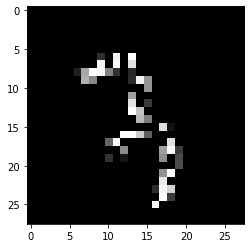

Label: 3


In [10]:
example_sparse = ds_train.take(1)
for sample in example_sparse:
    image, label = sample[0].numpy()*255, sample[1].numpy()
    plt.imshow(image[:, :, 0].astype(np.uint8), cmap=plt.get_cmap("gray"))
    plt.show()
    print("Label: %d" % label)

## viewing non-sparse test data

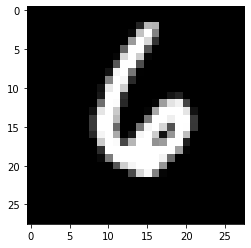

Label: 6


In [11]:
example_test = ds_test.take(1)
for sample in example_test:
    image, label = sample[0].numpy()*255, sample[1].numpy()
    plt.imshow(image[:, :, 0].astype(np.uint8), cmap=plt.get_cmap("gray"))
    plt.show()
    print("Label: %d" % label)

## regular steps follow

In [12]:

# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
ds_train.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
from custom_layers import splatter

In [16]:
layer = splatter(10, 3, input_shape=(28, 28, 1))

In [17]:
model = tf.keras.models.Sequential([
  splatter(
    filters=10,
    kernel_size=3,
    
    
    input_shape=( 28, 28, 1),
    
    ),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

hello
Tensor("Placeholder:0", shape=(None, 28, 28, 1), dtype=float32)
(None, 28, 28, 1)
Tensor("splatter_1/strided_slice:0", shape=(28, 28, 1), dtype=float32)
Tensor("splatter_1/strided_slice_2:0", shape=(28, 1), dtype=float32)
Tensor("splatter_1/strided_slice_3:0", shape=(28, 1), dtype=float32)
Tensor("splatter_1/strided_slice_5:0", shape=(1,), dtype=float32)
Tensor("splatter_1/strided_slice_7:0", shape=(28, 1), dtype=float32)
[[[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0

OperatorNotAllowedInGraphError: Exception encountered when calling layer "splatter_1" (type splatter).

iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)

In [ ]:
model.evaluate(ds_test )

79/79 [==============================] - 0s 4ms/step - loss: 2.9701 - sparse_categorical_accuracy: 0.0892


[2.9701249599456787, 0.08919999748468399]

In [ ]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
tf.keras.__version__

'2.8.0'